In [36]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd

import torch 
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F

from torchvision import datasets, transforms

# Normalization (Regularization) 
-> 오버피팅을 늦추고 Train 데이터로부터 적절한 특징을 학습하여 일반화 오차를 낮출 수 있는 기법

1. 가중치 감쇠 ( Weight Decay ) : L1, L2

2. 데이터 증강 ( Data Augmentation ) : 데이터에 노이즈를 추가 
 - 이미지 증강 
 - 생성 모델을 활용한 데이터 증강 ( GAN / AutoEncoder ) 

3. 드롭아웃 ( Dropout ) : 신경망 계층으로 구현 
 - 임의의 노드를 일정 확률로 드롭하여 학습에 참여하지 않도록 하는 방법 
 - 일반화 성능은 개선될 수 있지만 손실 값의 수렴 속도가 저하될 수 있고, 학습 오차가 증가할 수 있다. 

 4. 배치정규화 ( Batch Normalization ) : 신경망 계층으로 구현
  - 드롭아웃과 유사 But 학습 속도를 비약적 향상, 일반화 성능까지 대폭 개선  
  - 

In [6]:
# 드롭아웃 구현 
# Layer -> Act -> Dropout -> Layer 
# ! 보통 양 끝단에는 적용하지 않는다. 

p = 0.3 # 드롭아웃 확률

net = nn.Sequential(
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Dropout(p), ##
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Dropout(p), ##
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Dropout(p), ##
    nn.LeakyReLU(),
    nn.Dropout(p), ##
    nn.Linear(50, 10)
)

In [7]:
# 드롭아웃의 경우 학습에서만 적용, 추론(inference)에서는 드롭되는 노드 없이 모든 노드가 추론에 참여 
# train(), eval()  메서드를 활용해서 학습모드와 추론모드를 왔다갔다 하자 

'''
for epoch_idx in range(n_epochs):
    net.train()
    for iter_idx in range(n_train_iters):
        # Training procedure

    net.eval()
    for iter_idx in range(n_valid_iters):
        # Validation procedure
'''

In [ ]:
# 배치정규화 구현 
# Layer -> BN -> Act -> Layer 

net = nn.Sequential(
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.BatchNorm1d(200), ##
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.BatchNorm1d(100), ##
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.BatchNorm1d(50), ##
    nn.Linear(50, 10)
)

# 코드구현 

In [13]:
# Data Load

train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

x = train.data.float() / 255
y = train.targets 

x = x.view(x.size(0), -1)
print(x.shape, y.shape) 

input_size = x.size(-1)
output_size = int(max(y))+1

print(f'input_size : {input_size} / output_size : {output_size}')

torch.Size([60000, 784]) torch.Size([60000])
input_size : 784 / output_size : 10


In [16]:
# Train / Valid ratio 
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print(f'Train : {train_cnt} / Validation : {valid_cnt} / Test : {test_cnt} samples.')

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float()/255.).view(test_cnt, -1)]
y += [test.targets]


for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

Train : 48000 / Validation : 12000 / Test : 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


Build Model & Optimizer 

In [21]:
class Block(nn.Module):
    
    def __init__(self,
                 input_size,
                 output_size,
                 use_batch_norm=True,
                 dropout_p=.4):
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p
        
        super().__init__()
        
        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)
        
        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            get_regularizer(use_batch_norm, output_size),
        )
        
    def forward(self, x):
        # |x| = (batch_size, input_size)
        y = self.block(x)
        # |y| = (batch_size, output_size)
        
        return y

In [22]:
class MyModel(nn.Module):
    
    def __init__(self,
                 input_size,
                 output_size,
                 use_batch_norm=True,
                 dropout_p=.4):
        
        super().__init__()
        
        self.layers = nn.Sequential(
            Block(input_size, 500, use_batch_norm, dropout_p),
            Block(500, 400, use_batch_norm, dropout_p),
            Block(400, 300, use_batch_norm, dropout_p),
            Block(300, 200, use_batch_norm, dropout_p),
            Block(200, 100, use_batch_norm, dropout_p),
            nn.Linear(100, output_size),
            nn.LogSoftmax(dim=-1),
        )
        
    def forward(self, x):
        # |x| = (batch_size, input_size)        
        y = self.layers(x)
        # |y| = (batch_size, output_size)
        
        return y

In [23]:
model = MyModel(input_size,
                output_size,
                use_batch_norm=True)

model

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

In [24]:
crit = nn.NLLLoss()

In [25]:
optimizer = optim.Adam(model.parameters())

GPU 

In [26]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('cuda')

cuda


In [27]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

Train

In [30]:
# parameters 

n_epochs = 1000
batch_size = 256
print_interval = 10 

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [31]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train()
    
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss) # This is very important to prevent memory leak.

    train_loss = train_loss / len(x_)
        
    model.eval()
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train loss=2.0067e-02  valid_loss=8.9840e-02  lowest_loss=7.2884e-02
Epoch 20: train loss=9.7430e-03  valid_loss=8.8581e-02  lowest_loss=7.1021e-02
Epoch 30: train loss=6.5308e-03  valid_loss=7.8908e-02  lowest_loss=7.1021e-02
Epoch 40: train loss=3.6676e-03  valid_loss=8.6065e-02  lowest_loss=7.1021e-02
Epoch 50: train loss=6.5516e-03  valid_loss=7.6378e-02  lowest_loss=7.1021e-02
Epoch 60: train loss=3.4612e-03  valid_loss=7.5163e-02  lowest_loss=6.5959e-02
Epoch 70: train loss=2.4003e-03  valid_loss=8.6543e-02  lowest_loss=6.5959e-02
Epoch 80: train loss=3.7602e-03  valid_loss=8.0563e-02  lowest_loss=6.5959e-02
Epoch 90: train loss=1.7955e-03  valid_loss=7.7615e-02  lowest_loss=6.5959e-02
Epoch 100: train loss=2.0490e-03  valid_loss=7.8598e-02  lowest_loss=6.5959e-02
There is no improvement during last 50 epochs.
The best validation loss from epoch 52: 6.5959e-02


<All keys matched successfully>

Loss History 

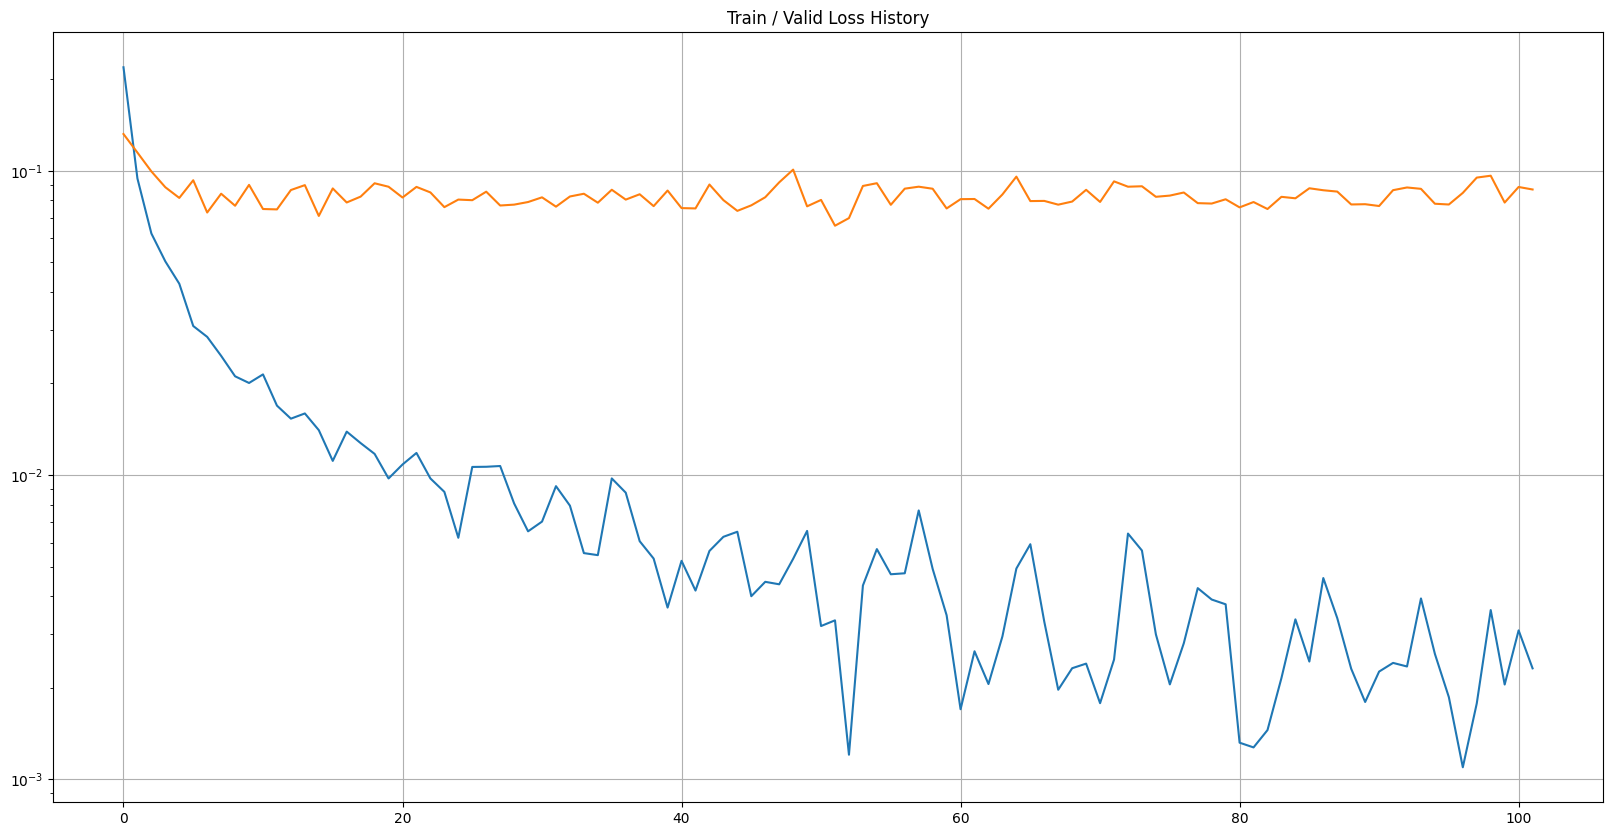

In [32]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

Result

In [33]:
test_loss = 0
y_hat = []

model.eval()
with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Test loss: %.4e" % test_loss)

Test loss: 6.7258e-02


In [34]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9852


In [46]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y[-1].detach().cpu(), torch.argmax(y_hat.detach().cpu(), dim=-1)),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,970,1,0,0,0,0,2,1,3,3
true_1,0,1129,1,1,0,0,2,0,2,0
true_2,1,0,1019,2,1,0,0,4,4,1
true_3,1,0,2,991,0,5,0,3,4,4
true_4,0,0,2,1,966,0,4,1,1,7
true_5,2,0,0,6,0,878,1,1,3,1
true_6,5,2,0,1,2,3,941,0,4,0
true_7,1,4,6,2,1,1,0,1008,1,4
true_8,0,0,2,2,1,3,0,3,960,3
true_9,0,2,0,1,9,2,0,3,2,990
